<a href="https://colab.research.google.com/github/AndersieMichael/Thesis/blob/main/evaluasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pandas as pd
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/dataMerge'
# path_to_dataset = '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge'
train_dir = os.path.join(path_to_dataset, 'train')
test_dir = os.path.join(path_to_dataset, 'test')

files = os.listdir(path_to_dataset)
print(files)

Mounted at /content/drive
['train', 'train.cache', 'test', 'test.cache']


In [3]:
!pip install pytictoc

In [4]:
pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=dc2674bcf2f0ca66a7e6bc6f1f5950aa70a768e0e2425755c8fdcefc97fe7e7f
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=2a210f59f06b265cd43825b569b3641d9f2ab925e309498cdc4d243406c4acb9
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [5]:
#initialisasi variable

mystate =32
imageSize = 224
epochs = 50
batch_size = 64
learningRate=0.001
weight_decay=0.0005
input_size = (3, imageSize, imageSize)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype

In [8]:
import torchvision.datasets as datasets

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Periksa distribusi kelas
class_counts = {}
for _, label in train_dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

class_names = train_dataset.classes

# Cetak informasi distribusi kelas
for class_name, count in zip(class_names, class_counts.values()):
    print(f"Class: {class_name}, Number of images: {count}")

Class: Acne, Number of images: 138
Class: Actinic Keratosis, Number of images: 138
Class: Basal Cell Carcinoma, Number of images: 138
Class: Eczemaa, Number of images: 138
Class: Rosacea, Number of images: 138


In [10]:
def optimizer_Setting(model):
        return torch.optim.Adam(model.parameters(), lr=learningRate,  weight_decay = weight_decay)


In [11]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Load the pretrained MobileNet V3 Small model
original_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV3, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of class based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model_v3_small = ModifiedMobileNetV3(num_classes)

# Freeze all layers except for the classifier
for param in model_v3_small.features.parameters():
    param.requires_grad = False
for param in model_v3_small.classifier.parameters():
    param.requires_grad = True

# Define the loss criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Placeholder for your optimizer setting function
optimizer = optimizer_Setting(model_v3_small)

# Set the device and move the model to it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v3_small = model_v3_small.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 34.3MB/s]


In [14]:
import torch
import torch.nn as nn
from fvcore.nn import FlopCountAnalysis
from pytictoc import TicToc
from sklearn.metrics import accuracy_score

def validate(model, test_loader):
    model.eval()
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # Initialize TicToc
    t = TicToc()
    all_preds = []
    all_labels = []

 # Ambil satu batch data untuk menghitung FLOPs
    example_inputs, _ = next(iter(test_loader))
    example_inputs = example_inputs.to(next(model.parameters()).device)

    # Hitung FLOPs menggunakan fvcore
    flops = FlopCountAnalysis(model, example_inputs)
    total_flops = flops.total()
    print(f"Total FLOPs: {total_flops / 1e9} GFLOPs")
    gflops = total_flops / 1e9

    t.tic()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    t.toc()

    # Calculate average loss over all batches
    avg_loss = running_loss / len(test_loader)
    print(f'Average Loss: {avg_loss:.4f}')

    # Hitung akurasi
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    total_time = t.tocvalue()
    print(f'Total prediction time: {total_time:.2f} second')
    print(f'Accuracy: {accuracy:.4f}')

    return accuracy*100, total_time, gflops

In [15]:
def validate_multiple_times(model, test_loader, num_runs=10):
    total_times = []

    for run in range(num_runs):
        print(f'\nValidation Run {run + 1}/{num_runs}:')
        accuracy, total_time, gflops = validate(model, test_loader)
        total_times.append(total_time)  # Store the total time for this run

    # Calculate average total time across all runs
    avg_total_time = sum(total_times) / num_runs
    print(f'\nAverage total prediction time over {num_runs} runs: {avg_total_time:.2f} seconds')

    return avg_total_time

In [16]:
mobileNetV3_small_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV3_small_best_model.pth'
# mobileNetV3_small_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV3_small_best_model.pth'

# Menghitung total jumlah parameter
total_params_mbv3s = sum(p.numel() for p in model_v3_small.parameters())


In [17]:

# Load model terbaik yang sudah disimpan
model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path, map_location=torch.device('cpu')))
# model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path))

# Validasi model dan ukur waktu prediksi
mobileNetV3_smallResult_dummy, mobileNetV3_small_time_dummy, mobileNetV3_small_gflops_dummy = validate(model_v3_small, test_loader)

<ipython-input-17-7f94f373e5bf>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path, map_location=torch.de

Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 36.664030 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 36.67 second
Accuracy: 0.6541


In [19]:
mobileNetV3_small_time_dummy = validate_multiple_times(model_v3_small, test_loader, 10)


Validation Run 1/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.856538 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.86 second
Accuracy: 0.6541

Validation Run 2/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.850662 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.85 second
Accuracy: 0.6541

Validation Run 3/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.867548 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.87 second
Accuracy: 0.6541

Validation Run 4/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.927931 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.93 second
Accuracy: 0.6541

Validation Run 5/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.876442 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.88 second
Accuracy: 0.6541

Validation Run 6/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.830293 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.83 second
Accuracy: 0.6541

Validation Run 7/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.833902 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.83 second
Accuracy: 0.6541

Validation Run 8/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.822727 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.82 second
Accuracy: 0.6541

Validation Run 9/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.918594 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.92 second
Accuracy: 0.6541

Validation Run 10/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.875764 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.88 second
Accuracy: 0.6541

Average total prediction time over 10 runs: 1.87 seconds


In [20]:

# Load model terbaik yang sudah disimpan
model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path, map_location=torch.device('cpu')))
# model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path))

# Validasi model dan ukur waktu prediksi
mobileNetV3_smallResult, mobileNetV3_small_time, mobileNetV3_small_gflops = validate(model_v3_small, test_loader)

<ipython-input-20-bd4ab8215b14>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path, map_location=torch.de

Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.810032 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.81 second
Accuracy: 0.6541


In [21]:
mobileNetV3_small_time = validate_multiple_times(model_v3_small, test_loader, 10)


Validation Run 1/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.850716 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.85 second
Accuracy: 0.6541

Validation Run 2/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.829360 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.83 second
Accuracy: 0.6541

Validation Run 3/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.887676 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.89 second
Accuracy: 0.6541

Validation Run 4/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.841286 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.84 second
Accuracy: 0.6541

Validation Run 5/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.857080 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.86 second
Accuracy: 0.6541

Validation Run 6/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.821741 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.82 second
Accuracy: 0.6541

Validation Run 7/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.924399 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.93 second
Accuracy: 0.6541

Validation Run 8/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.870733 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.87 second
Accuracy: 0.6541

Validation Run 9/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.837996 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.84 second
Accuracy: 0.6541

Validation Run 10/10:


Total FLOPs: 3.714469888 GFLOPs
Elapsed time is 1.844805 seconds.
Average Loss: 0.0000
Accuracy: 0.6541
Total prediction time: 1.85 second
Accuracy: 0.6541

Average total prediction time over 10 runs: 1.86 seconds


In [22]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Load pretrained MobileNet V3 large model
# model_v3_large = mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
# model_v3_large.classifier[3] = nn.Linear(model_v3_large.classifier[3].in_features,  len(class_names))  # Sesuaikan layer terakhir


# Load the pretrained MobileNet V3 Small model
original_model = mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV3, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of class based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model_v3_large = ModifiedMobileNetV3(num_classes)

# Freeze all layers except for the classifier
for param in model_v3_large.features.parameters():
    param.requires_grad = False
for param in model_v3_large.classifier.parameters():
    param.requires_grad = True


# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_v3_large.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_v3_large)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v3_large = model_v3_large.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 120MB/s] 


In [23]:
mobileNetV3_large_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV3_large_best_model.pth'
# mobileNetV3_large_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV3_large_best_model.pth'

# Menghitung total jumlah parameter
total_params_mbv3l = sum(p.numel() for p in model_v3_large.parameters())

In [24]:
# Load model terbaik yang sudah disimpan
# model_v3_large.load_state_dict(torch.load(mobileNetV3_large_save_path))
model_v3_large.load_state_dict(torch.load(mobileNetV3_large_save_path, map_location=torch.device('cpu')))

# Validasi model dan ukur waktu prediksi
mobileNetV3_largeResult, mobileNetV3_large_time, mobileNetV3_large_gflops = validate(model_v3_large, test_loader)

<ipython-input-24-0bdf6eecdb94>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3_large.load_state_dict(torch.load(mobileNetV3_large_save_path, map_location=torch.de

Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.906786 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.91 second
Accuracy: 0.7081


In [25]:
mobileNetV3_large_time = validate_multiple_times(model_v3_large, test_loader, 10)


Validation Run 1/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.834728 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.84 second
Accuracy: 0.7081

Validation Run 2/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.824373 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.83 second
Accuracy: 0.7081

Validation Run 3/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.849022 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.85 second
Accuracy: 0.7081

Validation Run 4/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.920594 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.92 second
Accuracy: 0.7081

Validation Run 5/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.902245 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.90 second
Accuracy: 0.7081

Validation Run 6/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.791819 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.79 second
Accuracy: 0.7081

Validation Run 7/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.842737 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.84 second
Accuracy: 0.7081

Validation Run 8/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.803561 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.80 second
Accuracy: 0.7081

Validation Run 9/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.887139 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.89 second
Accuracy: 0.7081

Validation Run 10/10:


Total FLOPs: 14.305908736 GFLOPs
Elapsed time is 1.847523 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.85 second
Accuracy: 0.7081

Average total prediction time over 10 runs: 1.85 seconds


In [26]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# Load pretrained EfficientNet B2 model
# model_efficientnet_b2 =

# Load the pretrained MobileNet V3 Small model
original_model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedEfficientNet, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of class based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model_efficientnet_b2 = ModifiedEfficientNet(num_classes)

# Freeze all layers except for the classifier
for param in model_efficientnet_b2.features.parameters():
    param.requires_grad = False
for param in model_efficientnet_b2.classifier.parameters():
    param.requires_grad = True


# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_efficientnet_b2.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_efficientnet_b2)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet_b2 = model_efficientnet_b2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 152MB/s]


In [27]:
efficientNet_b2_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/efficientNet_b2_best_model.pth'
# efficientNet_b2_save_path = '/content/drive/MyDrive/Colab/deep learning/efficientNet_b2_best_model.pth'

# Menghitung total jumlah parameter
total_params_efb2 = sum(p.numel() for p in model_efficientnet_b2.parameters())

In [28]:
# efficientNet_b2Result, efficientNet_b2_time, efficientNet_b2_gflops = evaluate_model(model_efficientnet_b2, criterion, test_loader, efficientNet_b2_save_path)

# Load model terbaik yang sudah disimpan
# model_efficientnet_b2.load_state_dict(torch.load(efficientNet_b2_save_path))
model_efficientnet_b2.load_state_dict(torch.load(efficientNet_b2_save_path, map_location=torch.device('cpu')))

# Validasi model dan ukur waktu prediksi
efficientNet_b2Result, efficientNet_b2_time, efficientNet_b2_gflops = validate(model_efficientnet_b2, test_loader)

<ipython-input-28-0569a3ca0caf>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_efficientnet_b2.load_state_dict(torch.load(efficientNet_b2_save_path, map_location=tor

Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.914655 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.92 second
Accuracy: 0.7081


In [29]:
efficientNet_b2_time = validate_multiple_times(model_efficientnet_b2, test_loader, 10)


Validation Run 1/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 2.018833 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 2.02 second
Accuracy: 0.7081

Validation Run 2/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.905175 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.91 second
Accuracy: 0.7081

Validation Run 3/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.932647 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.93 second
Accuracy: 0.7081

Validation Run 4/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.913489 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.92 second
Accuracy: 0.7081

Validation Run 5/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.971303 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.97 second
Accuracy: 0.7081

Validation Run 6/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.904031 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.91 second
Accuracy: 0.7081

Validation Run 7/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.874495 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.88 second
Accuracy: 0.7081

Validation Run 8/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.975832 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.98 second
Accuracy: 0.7081

Validation Run 9/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 2.002119 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 2.00 second
Accuracy: 0.7081

Validation Run 10/10:


features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.2.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.4.3.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.6.4.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth


Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 1.971783 seconds.
Average Loss: 0.0000
Accuracy: 0.7081
Total prediction time: 1.97 second
Accuracy: 0.7081

Average total prediction time over 10 runs: 1.95 seconds


In [30]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pretrained MobileNet V2 model
original_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV2, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of classes based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model = ModifiedMobileNetV2(num_classes)

# Freeze all layers except for the classifier
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model)

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_mobilenet_v2 = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 109MB/s] 


In [31]:

# Contoh penggunaan fungsi
# Pastikan model_mobilenet_v2, criterion, test_loader, dan mobileNetV2_save_path sudah terdefinisi
mobileNetV2_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV2_best_model.pth'
# mobileNetV2_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV2_best_model.pth'

# Menghitung total jumlah parameter
total_params_mbv2 = sum(p.numel() for p in model_mobilenet_v2.parameters())

# mobileNetV2Result, mobileNetV2_time, mobileNetV2_gflops = evaluate_model(model_mobilenet_v2, criterion, test_loader, mobileNetV2_save_path)

In [32]:
# Load model terbaik yang sudah disimpan
# model_mobilenet_v2.load_state_dict(torch.load(mobileNetV2_save_path))
model_mobilenet_v2.load_state_dict(torch.load(mobileNetV2_save_path, map_location=torch.device('cpu')))

# Validasi model dan ukur waktu prediksi
mobileNetV2Result, mobileNetV2_time, mobileNetV2_gflops = validate(model_mobilenet_v2, test_loader)

<ipython-input-32-fa176058db96>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mobilenet_v2.load_state_dict(torch.load(mobileNetV2_save_path, map_location=torch.devi

Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.902173 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.90 second
Accuracy: 0.7243


In [33]:
mobileNetV2_time = validate_multiple_times(model_mobilenet_v2, test_loader, 10)


Validation Run 1/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.945480 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.95 second
Accuracy: 0.7243

Validation Run 2/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.924632 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.93 second
Accuracy: 0.7243

Validation Run 3/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.857315 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.86 second
Accuracy: 0.7243

Validation Run 4/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.840794 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.84 second
Accuracy: 0.7243

Validation Run 5/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.871520 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.87 second
Accuracy: 0.7243

Validation Run 6/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.897073 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.90 second
Accuracy: 0.7243

Validation Run 7/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.912499 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.91 second
Accuracy: 0.7243

Validation Run 8/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.864685 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.87 second
Accuracy: 0.7243

Validation Run 9/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.817952 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.82 second
Accuracy: 0.7243

Validation Run 10/10:


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 1.898721 seconds.
Average Loss: 0.0000
Accuracy: 0.7243
Total prediction time: 1.90 second
Accuracy: 0.7243

Average total prediction time over 10 runs: 1.88 seconds


In [34]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 32.9/235.7 GB disk)


In [35]:
from ultralytics import YOLO

In [36]:
modelyolov8s = YOLO('/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/yolov8s-cls-local.pt')  # load a pretrained YOLOv8n detection model
modelyolov8s.info()

YOLOv8s-cls summary: 99 layers, 6,361,736 parameters, 0 gradients, 13.6 GFLOPs


(99, 6361736, 0, 13.609779199999998)

In [37]:
# Train the model
results = modelyolov8s.train(data='/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform', epochs=epochs, imgsz=imageSize, lr0 = learningRate, optimizer = 'Adam', batch =batch_size, name ='yoloS')

New https://pypi.org/project/ultralytics/8.3.44 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/yolov8s-cls-local.pt, data=/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform, epochs=50, time=None, patience=100, batch=64, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yoloS, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.0MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/train... 690 images, 0 corrupt: 100%|██████████| 690/690 [00:22<00:00, 31.07it/s]


train: New cache created: /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/train.cache


val: Scanning /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test... 185 images, 0 corrupt: 100%|██████████| 185/185 [00:05<00:00, 31.94it/s]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test.cache
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/yoloS
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50      1.43G      1.558         64        224:  82%|████████▏ | 9/11 [00:01<00:00, 10.18it/s]

               classes   top1_acc   top5_acc:   0%|          | 0/2 [00:00<?, ?it/s]
100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all      0.389          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.64it/s]

                   all      0.557          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 47.02it/s]

                   all      0.535          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 59.85it/s]

                   all      0.595          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 59.66it/s]

                   all      0.654          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.76it/s]

                   all      0.622          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 60.81it/s]

                   all      0.681          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 69.20it/s]

                   all      0.681          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 66.70it/s]

                   all      0.686          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.43G     0.4053         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 59.80it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.43G     0.3907         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.26it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.43G     0.3661         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 76.11it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.43G     0.3653         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.93it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.43G     0.3412         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.33it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.43G     0.3082         50        224: 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 66.45it/s]

                   all      0.665          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.43G     0.2697         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.43it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.43G     0.2617         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.83it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.43G     0.2038         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 76.32it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.43G     0.2426         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.54it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      1.43G     0.2075         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.64it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      1.43G     0.2289         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]

                   all      0.665          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      1.43G     0.2009         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 64.62it/s]

                   all      0.714          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      1.43G     0.1937         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.60it/s]

                   all      0.714          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      1.43G     0.1839         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 63.63it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      1.43G     0.1502         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 60.22it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.43G     0.1255         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 73.53it/s]

                   all      0.719          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.43G     0.1205         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.80it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.43G     0.1592         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 56.61it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.43G     0.1033         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.16it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.43G     0.1688         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.44it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.43G     0.1111         50        224: 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 68.17it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.43G      0.135         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 56.64it/s]

                   all      0.697          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.43G     0.1433         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 63.07it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.43G    0.08176         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.02it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      1.43G    0.09665         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 61.04it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.43G    0.08905         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 57.85it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.43G    0.09214         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.00it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.43G    0.09533         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 76.76it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      1.43G    0.08234         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.00it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      1.43G    0.09664         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 69.56it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.43G    0.07226         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 68.08it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.43G     0.0807         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 76.12it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.43G     0.1073         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 62.49it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.43G    0.05972         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 69.31it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.43G    0.06817         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.92it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      1.43G    0.06151         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.58it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      1.43G    0.06688         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.37it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      1.43G     0.0646         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 59.52it/s]

                   all      0.795          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      1.43G    0.04597         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 73.87it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      1.43G    0.05984         50        224: 100%|██████████| 11/11 [00:01<00:00,  8.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.41it/s]

                   all      0.789          1



50 epochs completed in 0.037 hours.
Optimizer stripped from runs/classify/yoloS/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/yoloS/weights/best.pt, 10.3MB

Validating runs/classify/yoloS/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,081,605 parameters, 0 gradients, 12.5 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/train... found 690 images in 5 classes ✅ 
val: None...
test: /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test... found 185 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 30.76it/s]


                   all      0.795          1
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yoloS
Results saved to runs/classify/yoloS


In [38]:
results

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba51ef320b0>
curves: []
curves_results: []
fitness: 0.8972972929477692
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7945945858955383, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8972972929477692}
save_dir: PosixPath('runs/classify/yoloS')
speed: {'preprocess': 0.08962476575696791, 'inference': 0.07182456351615286, 'loss': 0.00022037609203441722, 'postprocess': 0.0001881573651288007}
task: 'classify'
top1: 0.7945945858955383
top5: 1.0

In [39]:
bestModelYoloS = YOLO('/content/runs/classify/yoloS/weights/best.pt')  # load a custom model

In [40]:
# Total parameter untuk masing-masing model
path_class = ['/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne',
              '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Actinic Keratosis',
              '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Basal Cell Carcinoma',
              '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Eczemaa',
              '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Rosacea']

In [41]:
def evaluate_model_yolo(model, model_path, device=None):
  # Setup TicToc
  t = TicToc()
  # List to store prediction results
  prediction_tests = []
  if device is None:
        # Automatically choose the device: Use GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to the selected device
  model.to(device)
  t.tic()  # Start timing
  # Proses untuk setiap predictionTest
  for i in range(5):
    prediction_result = model.predict(model_path[i])
    prediction_tests.append(prediction_result)

  t.toc()  # Stop timing and get total time
  # Menggunakan total waktu evaluasi
  elapsed_time_s = t.elapsed
  print(f"Total Prediction Time: {elapsed_time_s:.2f} seconds")

  return prediction_tests, elapsed_time_s

In [42]:
def validate_model_yolo_multiple_times(model, model_path, device=None, num_runs=10):
    total_times = []  # List to store total prediction times for each run

    for run in range(num_runs):
        print(f'\nRun {run + 1}/{num_runs}:')
        prediction_tests, total_prediction_time = evaluate_model_yolo(model, model_path, device)  # Call your existing function
        total_times.append(total_prediction_time)  # Store the total prediction time for this run

    # Calculate the average total prediction time across all runs in milliseconds
    avg_total_time = sum(total_times) / num_runs
    print(f'\nAverage total prediction time over {num_runs} runs: {avg_total_time:.2f} seconds')  # Print average time in ms

    return avg_total_time

In [43]:
prediction_tests,total_inference_time_yolov8S_percobaan = evaluate_model_yolo(bestModelYoloS,path_class)


image 1/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032839HB.jpg: 224x224 Acne 0.56, Eczemaa 0.43, Rosacea 0.01, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, 3.7ms
image 2/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032897HB.jpg: 224x224 Acne 1.00, Actinic Keratosis 0.00, Rosacea 0.00, Eczemaa 0.00, Basal Cell Carcinoma 0.00, 3.9ms
image 3/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/07AcnePittedScars1.jpg: 224x224 Acne 1.00, Eczemaa 0.00, Rosacea 0.00, Actinic Keratosis 0.00, Basal Cell Carcinoma 0.00, 3.5ms
image 4/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/acne-Closed-Comedo.jpg: 224x224 Eczemaa 1.00, Basal Cell Carcinoma 0.00, Acne 0.00, Rosacea 0.00, Actinic Keratosis 0.00, 3.9ms
image 5/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/tr

In [44]:
# Set device to CUDA if available; otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now call the validate_multiple_times function with all required arguments
total_inference_time_yolov8S_percobaan = validate_model_yolo_multiple_times(bestModelYoloS, path_class, device, num_runs=10)


Run 1/10:

image 1/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032839HB.jpg: 224x224 Acne 0.56, Eczemaa 0.43, Rosacea 0.01, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, 3.6ms
image 2/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032897HB.jpg: 224x224 Acne 1.00, Actinic Keratosis 0.00, Rosacea 0.00, Eczemaa 0.00, Basal Cell Carcinoma 0.00, 4.4ms
image 3/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/07AcnePittedScars1.jpg: 224x224 Acne 1.00, Eczemaa 0.00, Rosacea 0.00, Actinic Keratosis 0.00, Basal Cell Carcinoma 0.00, 3.5ms
image 4/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/acne-Closed-Comedo.jpg: 224x224 Eczemaa 1.00, Basal Cell Carcinoma 0.00, Acne 0.00, Rosacea 0.00, Actinic Keratosis 0.00, 3.3ms
image 5/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi

In [45]:
total_correct_predictions = 0
total_all_predictions = 0
total_running_loss = 0.0  # to accumulate the total loss


# Proses untuk setiap predictionTest
for i, predictionTest in enumerate(prediction_tests):
    correct_predictions = 0
    true_label = i  # karena semua ground truth di predictionTesti adalah i

    for result in predictionTest:
        predicted_label = result.probs.top1  # asumsi bahwa probs.top1 adalah label prediksi teratas
        if predicted_label == true_label:
            correct_predictions += 1

    # Jumlah total prediksi untuk setiap kelas
    total_predictions = len(predictionTest)
    total_all_predictions += total_predictions
    total_correct_predictions += correct_predictions

    # Akurasi untuk kelas ini
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Akurasi untuk predictionTest{i}: {accuracy:.2f}%")

# Akurasi keseluruhan
overall_accuracy_yolov8S = (total_correct_predictions / total_all_predictions) * 100

print(f"Akurasi keseluruhan model: {overall_accuracy_yolov8S:.2f}%")
# print(f"Total waktu inferensi: {total_inference_time_yolov8S:.2f} detik")

Akurasi untuk predictionTest0: 89.19%
Akurasi untuk predictionTest1: 56.76%
Akurasi untuk predictionTest2: 83.78%
Akurasi untuk predictionTest3: 78.38%
Akurasi untuk predictionTest4: 86.49%
Akurasi keseluruhan model: 78.92%


In [46]:
modelyolov8n = YOLO('/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/yolov8n-cls-local.pt')  # load a pretrained YOLOv8n detection model
modelyolov8n.info()

YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 0 gradients, 4.4 GFLOPs


(99, 2719288, 0, 4.383948800000001)

In [47]:
# Train the model
results = modelyolov8n.train(data='/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform', epochs=epochs, imgsz=imageSize, lr0 = learningRate, optimizer = 'Adam', batch =batch_size, name ='yolon')

New https://pypi.org/project/ultralytics/8.3.44 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/yolov8n-cls-local.pt, data=/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform, epochs=50, time=None, patience=100, batch=64, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolon, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid

train: Scanning /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/train... 690 images, 0 corrupt: 100%|██████████| 690/690 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test... 185 images, 0 corrupt: 100%|██████████| 185/185 [00:00<?, ?it/s]


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/yolon
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]

                   all      0.346          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 61.67it/s]

                   all      0.514          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 73.69it/s]

                   all      0.443          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 67.82it/s]

                   all      0.551          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 80.22it/s]

                   all      0.659          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 57.62it/s]

                   all      0.578          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 83.99it/s]

                   all        0.6          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.00it/s]

                   all      0.665          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 78.18it/s]

                   all      0.622          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.816G     0.6218         50        224: 100%|██████████| 11/11 [00:01<00:00,  8.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.05it/s]

                   all      0.622          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.816G     0.5623         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 56.14it/s]

                   all      0.659          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.816G     0.4778         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.33it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.816G     0.4847         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 78.93it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.816G     0.4583         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 64.15it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.816G     0.4012         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 68.78it/s]

                   all      0.697          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.816G     0.3935         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 79.69it/s]

                   all      0.681          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.816G     0.3495         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.11it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.814G     0.3361         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 81.84it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.816G      0.303         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.16it/s]

                   all      0.714          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.814G     0.3281         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.39it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.816G     0.3133         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 82.17it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.816G     0.3002         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 73.39it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.814G     0.2341         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 76.43it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.816G     0.2907         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.52it/s]

                   all      0.703          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.814G     0.2591         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.64it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.816G     0.1916         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 58.74it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.814G     0.2323         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.14it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.816G     0.2353         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 63.12it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.816G     0.2274         50        224: 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.83it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.814G     0.2378         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 66.31it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.816G     0.1598         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 59.71it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.816G     0.1853         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 58.54it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.816G     0.1986         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.00it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.816G     0.1386         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 74.91it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.816G     0.1494         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 80.90it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.814G     0.1621         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.09it/s]

                   all      0.724          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.816G     0.1451         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 81.50it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.816G     0.1586         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 64.43it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.816G     0.1601         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.31it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.816G     0.1435         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 70.04it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.816G     0.1444         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 56.37it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.814G     0.1299         50        224: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.38it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.816G     0.1445         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 72.36it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.814G     0.1025         50        224: 100%|██████████| 11/11 [00:01<00:00,  5.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 69.71it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.816G     0.1221         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 69.08it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.816G     0.1405         50        224: 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 71.29it/s]


                   all      0.719          1

      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.814G     0.1129         50        224: 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 75.73it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.816G     0.1357         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 77.00it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.816G     0.1168         50        224: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 61.12it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.816G     0.1297         50        224: 100%|██████████| 11/11 [00:01<00:00,  7.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 60.62it/s]

                   all      0.735          1



50 epochs completed in 0.037 hours.
Optimizer stripped from runs/classify/yolon/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/yolon/weights/best.pt, 3.0MB

Validating runs/classify/yolon/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,441,285 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/train... found 690 images in 5 classes ✅ 
val: None...
test: /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test... found 185 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 84.22it/s]


                   all      0.762          1
Speed: 0.1ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolon
Results saved to runs/classify/yolon


In [48]:
bestModelYoloN = YOLO('/content/runs/classify/yolon/weights/best.pt')  # load a custom model

In [49]:
results

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba51ff9c640>
curves: []
curves_results: []
fitness: 0.8810810744762421
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7621621489524841, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8810810744762421}
save_dir: PosixPath('runs/classify/yolon')
speed: {'preprocess': 0.05211959014067779, 'inference': 0.05092620849609375, 'loss': 0.00012243116224134289, 'postprocess': 0.00011727616593644427}
task: 'classify'
top1: 0.7621621489524841
top5: 1.0

In [50]:
prediction_tests_yolov8N,total_inference_time_yolov8N_percobaan = evaluate_model_yolo(bestModelYoloN,path_class)


image 1/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032839HB.jpg: 224x224 Acne 0.81, Eczemaa 0.14, Rosacea 0.03, Actinic Keratosis 0.01, Basal Cell Carcinoma 0.01, 3.5ms
image 2/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032897HB.jpg: 224x224 Acne 0.97, Rosacea 0.01, Actinic Keratosis 0.01, Eczemaa 0.01, Basal Cell Carcinoma 0.00, 3.4ms
image 3/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/07AcnePittedScars1.jpg: 224x224 Acne 1.00, Eczemaa 0.00, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, Rosacea 0.00, 3.4ms
image 4/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/acne-Closed-Comedo.jpg: 224x224 Eczemaa 0.97, Basal Cell Carcinoma 0.03, Rosacea 0.01, Actinic Keratosis 0.00, Acne 0.00, 4.4ms
image 5/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/tr

In [51]:
# Set device to CUDA if available; otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now call the validate_multiple_times function with all required arguments
total_inference_time_yolov8N_percobaan = validate_model_yolo_multiple_times(bestModelYoloN, path_class, device, num_runs=10)


Run 1/10:

image 1/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032839HB.jpg: 224x224 Acne 0.81, Eczemaa 0.14, Rosacea 0.03, Actinic Keratosis 0.01, Basal Cell Carcinoma 0.01, 5.8ms
image 2/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/032897HB.jpg: 224x224 Acne 0.97, Rosacea 0.01, Actinic Keratosis 0.01, Eczemaa 0.01, Basal Cell Carcinoma 0.00, 4.8ms
image 3/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/07AcnePittedScars1.jpg: 224x224 Acne 1.00, Eczemaa 0.00, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, Rosacea 0.00, 3.5ms
image 4/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/transform/test/Acne/acne-Closed-Comedo.jpg: 224x224 Eczemaa 0.97, Basal Cell Carcinoma 0.03, Rosacea 0.01, Actinic Keratosis 0.00, Acne 0.00, 4.3ms
image 5/37 /content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi

In [52]:
total_correct_predictions = 0
total_all_predictions = 0

# Proses untuk setiap predictionTest
for i, predictionTest in enumerate(prediction_tests_yolov8N):
    correct_predictions = 0
    true_label = i  # karena semua ground truth di predictionTesti adalah i

    for result in predictionTest:
        predicted_label = result.probs.top1  # asumsi bahwa probs.top1 adalah label prediksi teratas
        if predicted_label == true_label:
            correct_predictions += 1

    # Jumlah total prediksi untuk setiap kelas
    total_predictions = len(predictionTest)
    total_all_predictions += total_predictions
    total_correct_predictions += correct_predictions

    # Akurasi untuk kelas ini
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Akurasi untuk predictionTest{i}: {accuracy:.2f}%")

# Akurasi keseluruhan
overall_accuracy_yolov8N = (total_correct_predictions / total_all_predictions) * 100

print(f"Akurasi keseluruhan model: {overall_accuracy_yolov8N:.2f}%")
# print(f"Total waktu inferensi: {total_inference_time_yolov8S:.2f} detik")

Akurasi untuk predictionTest0: 86.49%
Akurasi untuk predictionTest1: 56.76%
Akurasi untuk predictionTest2: 75.68%
Akurasi untuk predictionTest3: 72.97%
Akurasi untuk predictionTest4: 89.19%
Akurasi keseluruhan model: 76.22%


In [53]:
# Membuat array string
array_model = ["MobileNetV2", "MobileNetV3Small", "MobileNetV3Large", "EfficientNetB2" , "YOLOV8N-cls", "YOLOV8S-cls"]

# Menampilkan array string
print(array_model)

['MobileNetV2', 'MobileNetV3Small', 'MobileNetV3Large', 'EfficientNetB2', 'YOLOV8N-cls', 'YOLOV8S-cls']


In [54]:
best_accuracies = [mobileNetV2Result, mobileNetV3_smallResult, mobileNetV3_largeResult, efficientNet_b2Result, overall_accuracy_yolov8N, overall_accuracy_yolov8S]

In [55]:
best_accuracies

[72.43243243243244,
 65.4054054054054,
 70.8108108108108,
 70.8108108108108,
 76.21621621621621,
 78.91891891891892]

In [56]:
import matplotlib.pyplot as plt

def plot_model_inference_time(model_names, accuracies, inference_times ):
    # Membuat scatter plot
    plt.figure(figsize=(10, 5))
    for i in range(len(model_names)):
        plt.scatter(inference_times[i], accuracies[i], label=model_names[i])

    # Menambahkan judul dan label
    plt.title('Relationship Between Inference Time and Model Accuracy')
    plt.xlabel('Inference Time (seconds)')
    plt.ylabel('Accuracy (%)')

    # Menambahkan legenda
    plt.legend()

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan grafik
    plt.show()

In [57]:
inference_times = [mobileNetV2_time, mobileNetV3_small_time, mobileNetV3_large_time, efficientNet_b2_time, total_inference_time_yolov8N_percobaan,  total_inference_time_yolov8S_percobaan]

In [58]:
inference_times

[1.8845079438000085,
 1.8580347989999837,
 1.8520472516999917,
 1.9487213298000143,
 2.1959149744000115,
 2.2055580459999873]

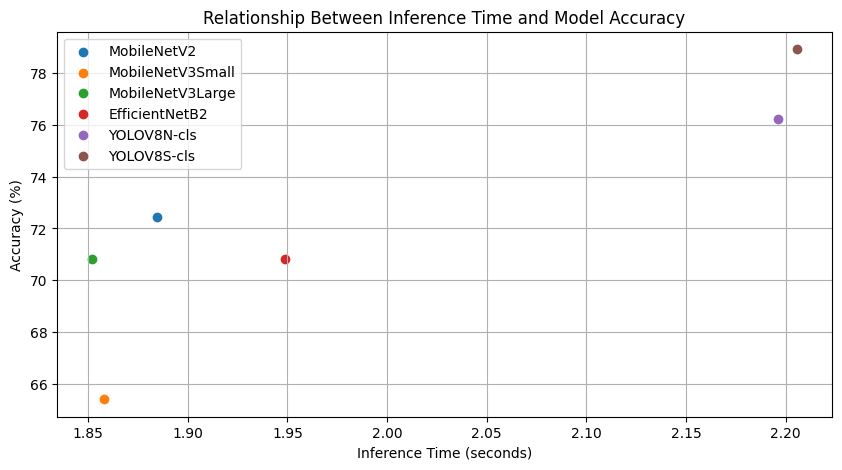

In [59]:
plot_model_inference_time(array_model, best_accuracies, inference_times)

In [60]:
def get_gflops_input(prompt):
    while True:
        try:
            # Meminta input dari pengguna
            user_input = input(prompt)
            # Mengkonversi input ke tipe float
            gflops = float(user_input)
            if gflops < 0:
                raise ValueError("GFLOPs tidak boleh negatif.")
            return gflops
        except ValueError as e:
            # Jika konversi gagal atau input negatif, berikan pesan kesalahan dan minta lagi
            print("Error:", e)
            print("Silakan masukkan angka yang valid untuk GFLOPs.")

In [61]:
modelyolov8n.info()

YOLOv8n-cls summary: 99 layers, 1,444,693 parameters, 0 gradients, 3.4 GFLOPs


(99, 1444693, 0, 3.3650687999999995)

In [62]:
# Meminta pengguna memasukkan GFLOPs
gflops_yoloV8n = get_gflops_input("Masukkan jumlah GFLOPs: ")
print("Jumlah GFLOPs yang Anda masukkan adalah:", gflops_yoloV8n)


Masukkan jumlah GFLOPs: 3.4 
Jumlah GFLOPs yang Anda masukkan adalah: 3.4


In [63]:
modelyolov8s.info()

YOLOv8s-cls summary: 99 layers, 5,087,141 parameters, 0 gradients, 12.6 GFLOPs


(99, 5087141, 0, 12.5908992)

In [64]:
# Meminta pengguna memasukkan GFLOPs
gflops_yoloV8s = get_gflops_input("Masukkan jumlah GFLOPs: ")
print("Jumlah GFLOPs yang Anda masukkan adalah:", gflops_yoloV8s)


Masukkan jumlah GFLOPs: 12.6 
Jumlah GFLOPs yang Anda masukkan adalah: 12.6


In [65]:
Glops_model = [mobileNetV2_gflops, mobileNetV3_small_gflops, mobileNetV3_large_gflops, efficientNet_b2_gflops, gflops_yoloV8n,  gflops_yoloV8s]

In [66]:
def plot_model_Gflops(model_names, accuracies, flops):
    # Membuat scatter plot
    plt.figure(figsize=(10, 5))
    for i in range(len(model_names)):
        plt.scatter(flops[i], accuracies[i], label=model_names[i])

    # Menambahkan judul dan label
    plt.title('The Relationship Between FLOPs and Model Accuracy')
    plt.xlabel('FLOPs (GFLOPs)')
    plt.ylabel('Accuracy (%)')

    # Menambahkan legenda
    plt.legend()

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan grafik
    plt.show()


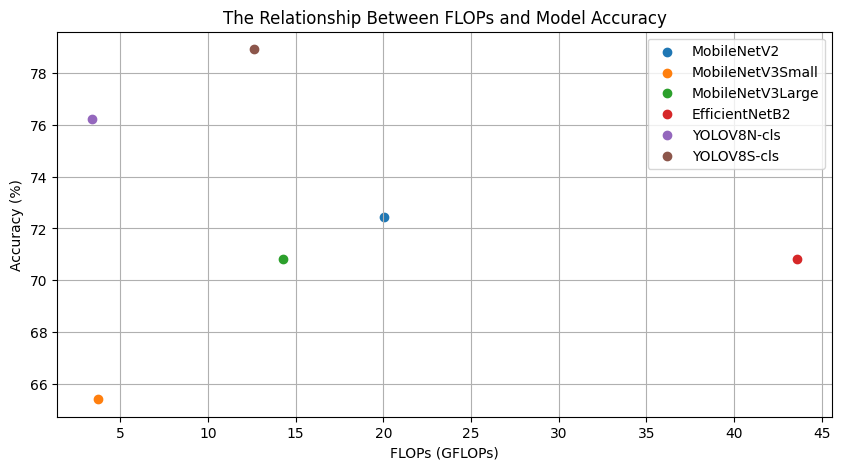

In [67]:
plot_model_Gflops(array_model, best_accuracies, Glops_model)

In [68]:
modelyolov8n.info()

YOLOv8n-cls summary: 99 layers, 1,444,693 parameters, 0 gradients, 3.4 GFLOPs


(99, 1444693, 0, 3.3650687999999995)

In [69]:
# Meminta pengguna memasukkan GFLOPs
total_params_yolov8n = get_gflops_input("Masukkan jumlah total_params: ")
print("Jumlah total_params yang Anda masukkan adalah:", total_params_yolov8n)


Masukkan jumlah total_params: 1444693
Jumlah total_params yang Anda masukkan adalah: 1444693.0


In [70]:
modelyolov8s.info()

YOLOv8s-cls summary: 99 layers, 5,087,141 parameters, 0 gradients, 12.6 GFLOPs


(99, 5087141, 0, 12.5908992)

In [71]:
# Meminta pengguna memasukkan GFLOPs
total_params_yolov8s = get_gflops_input("Masukkan jumlah total_params: ")
print("Jumlah total_params yang Anda masukkan adalah:", total_params_yolov8s)


Masukkan jumlah total_params: 5087141
Jumlah total_params yang Anda masukkan adalah: 5087141.0


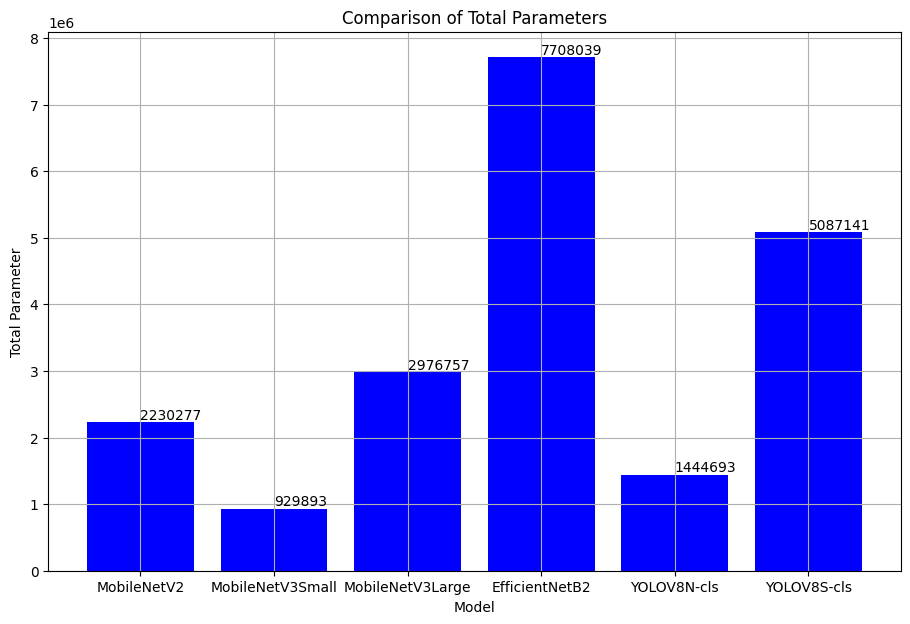

In [72]:
import matplotlib.pyplot as plt


# Total parameter untuk masing-masing model
total_params = [total_params_mbv2, total_params_mbv3s, total_params_mbv3l, total_params_efb2, total_params_yolov8n, total_params_yolov8s]

# Membuat bar chart
plt.figure(figsize=(11, 7))
bars = plt.bar(array_model, total_params, color='blue')

# Menambahkan judul dan label
plt.title('Comparison of Total Parameters')
plt.xlabel('Model')
plt.ylabel('Total Parameter')

# Menampilkan grid
plt.grid(True)

# Menampilkan angka pada setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom')  # Posisi teks di atas setiap bar

# Menampilkan grafik
plt.show()
